In [15]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import PathCollection

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

from scipy.optimize import curve_fit

module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

# Importer le module
import utils_v2 as u

import pandas as pd

In [16]:
#import datas
Air01 = pd.read_csv('/workspaces/TP3/TP_Plasma/Datas/AIR0001.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
Air01_V = Air01.iloc[:,0]
Air01_I = Air01.iloc[:,1]

Air12 = pd.read_csv('/workspaces/TP3/TP_Plasma/Datas/AIR0012.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
Air12_V = Air12.iloc[:,0]
Air12_I = Air12.iloc[:,1]

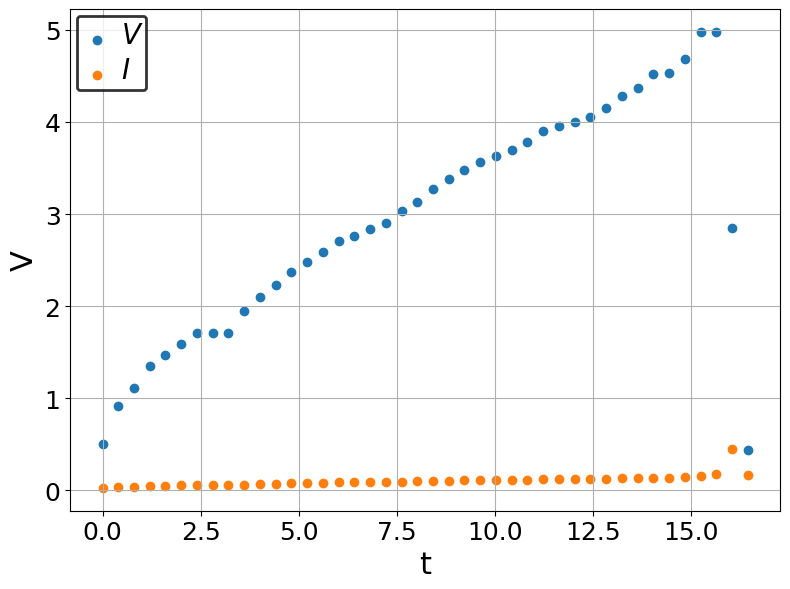

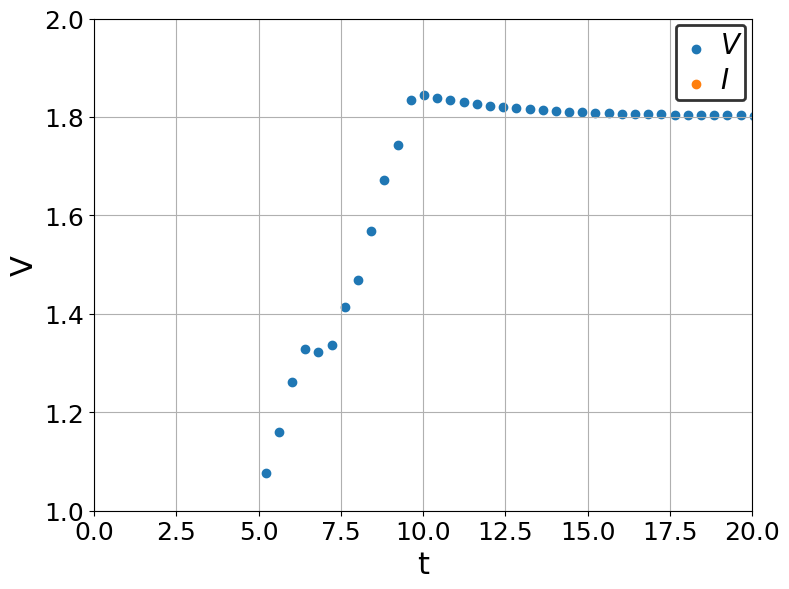

In [ ]:
#plot
dt = 0.401

